In [1]:
import numpy as np
import scipy.optimize as so
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(0)

In [2]:
T = 10              # Time
N = 10              # Number of time steps
dt = T // N         # Time per step

F = 500_000_000     # Total to invest

In [3]:
### Rate Term Structure Data

# Treasury Rate
tsy = np.array([0.0312, 0.0320, 0.0325, 0.0328, 0.0333, 0.0337, 0.0340, 0.0343, 0.0345, 0.0347])
D_tsy = 1 / (1 + tsy) ** np.array(range(1, len(tsy) + 1), dtype=int)

# TED Rate
ted = np.array([0.0045, 0.0094, 0.0084, 0.0095, 0.0092, 0.0089, 0.0087, 0.0085, 0.0084, 0.0083])
lib = tsy + ted
D_lib = 1 / (1 + lib) ** np.array(range(1, len(tsy) + 1), dtype=int)

### Volatility Term Structure Data

# Treasury Volatility
v_tsy = np.array([0.15, 0.15, 0.15, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

# TED Volatility
v_ted = 0.05

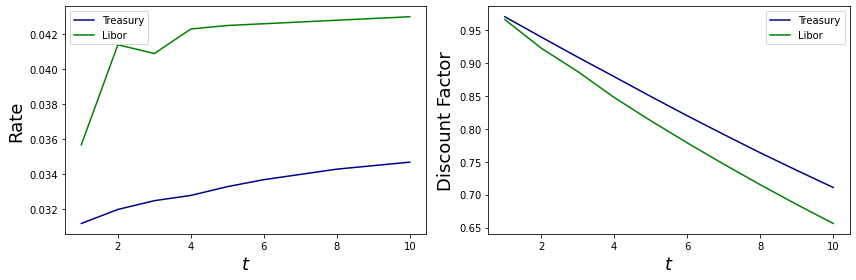

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(range(1, T + 1), tsy, color='darkblue', label='Treasury')
axs[0].plot(range(1, T + 1), lib, color='green', label='Libor')
axs[0].set_xlabel('$t$', fontsize=18); axs[0].set_ylabel('Rate', fontsize=18); axs[0].legend()

axs[1].plot(range(1, T + 1), D_tsy, color='darkblue', label='Treasury')
axs[1].plot(range(1, T + 1), D_lib, color='green', label='Libor')
axs[1].set_xlabel('$t$', fontsize=18); axs[1].set_ylabel('Discount Factor', fontsize=18); axs[1].legend()

plt.tight_layout()
plt.show()

# Generate Random Normals

In [5]:
N_paths = 1_000_000     # Number of Paths
rho = 0.1               # Correlation of stochastic movements in the treasury rate and the ted spread

# Generate correlated random normals
Z = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], size=N_paths * N)
Z_tsy, Z_ted = Z[:, 0].reshape(N_paths, N), Z[:, 1].reshape(N_paths, N)

# Nomenclature

* `r`: An `N_paths` by `N` matrix of treasury rates
* `s`: An `N_paths` by `N` matrix of ted spread rates
* `l`: An `N_paths` by `N` matrix of libor rates
    * `l` = `r` + `s`
* `g`: An `N_paths` by `N` matrix of GMNA rates
* `cpr`: An `N_paths` by `N` matrix of pre-payment rates

# Simulate Treasury Rate Paths

<center> Hull-White </center>

\begin{equation}
dr_t = \alpha \big( \theta_t - \ r_t \big) \ dt + \sigma_t \ dW_t
\end{equation}

In [6]:
alpha_tsy = 0.1             # Mean reversion parameter
theta_tsy_guess = 0.03      # Initial guess for each mean reversion level

r = np.zeros((N_paths, N))  # Matrix of treasury rates
r[:, 0] = tsy[0]            # Set the initial rate

In [7]:
theta_tsy = []
for i, t in tqdm(enumerate(range(2, T + 1)), total=T - 1):
    
    # Define a function to minimize the difference between the empirical and market discount factors
    def squared_diff_tsy(_theta):
        r_temp = r.copy()
        r_temp[:, i + 1] = r_temp[:, i] + alpha_tsy * (_theta - r_temp[:, i]) * dt + (v_tsy[i] * r_temp[:, i]) * np.sqrt(dt) * Z_tsy[:, i]
        D_tsy_emp = np.prod(1 / (1 + r_temp[:, :i + 2]), axis=1).mean()
        return (D_tsy[i + 1] - D_tsy_emp) ** 2

    # Calculate the optimal theta and record it
    result = so.minimize(squared_diff_tsy, theta_tsy_guess)
    theta_tsy.append(float(result.x))

    # Use the optimal theta to calculate the new rate
    r[:, i + 1] = r[:, i] + alpha_tsy * (theta_tsy[i] - r[:, i]) * dt + (v_tsy[i] * r[:, i]) * np.sqrt(dt) * Z_tsy[:, i]

del squared_diff_tsy

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.81s/it]


In [8]:
df = pd.DataFrame(theta_tsy, index=['theta_{:d},{:d}'.format(i - 1, i) for i in range(2, T + 1)])
df.T

,"theta_1,2","theta_2,3","theta_3,4","theta_4,5","theta_5,6","theta_6,7","theta_7,8","theta_8,9","theta_9,10"
0,0.047404,0.04035,0.0361,0.049767,0.041137,0.036916,0.042641,0.034291,0.041041


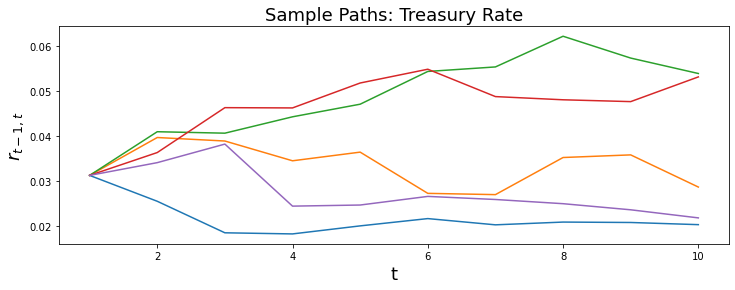

In [9]:
plt.figure(figsize=(12, 4))

for i in range(5):
    plt.plot(range(1, T + 1), r[i])

plt.xlabel(r't', fontsize=18)
plt.ylabel(r'$r_{t - 1, t}$', fontsize=18)
plt.title('Sample Paths: Treasury Rate', fontsize=18)

plt.show()

# Simulate TED Rate Paths

In [10]:
alpha_ted = 1.8             # Mean reversion parameter
theta_ted_guess = 0.03      # Initial guess for each mean reversion level

s = np.zeros((N_paths, N))  # Matrix of treasury rates
s[:, 0] = ted[0]            # Set the initial rates

In [11]:
theta_ted = []
for i, t in tqdm(enumerate(range(2, T + 1)), total=T - 1):
    
    # Define a function to minimize the difference between the empirical and market LIBOR discount factors
    def squared_diff_lib(_theta):
        s_temp = s.copy()
        s_temp[:, i + 1] = s_temp[:, i] + alpha_ted * (_theta - s_temp[:, i]) * dt + (v_ted * s_temp[:, i]) * np.sqrt(dt) * Z_ted[:, i]
        lib_temp = r + s_temp
        D_lib_emp = np.prod(1 / (1 + lib_temp[:, :i + 2]), axis=1).mean()
        return (D_lib[i + 1] - D_lib_emp) ** 2

    # Calculate the optimal theta and record it
    result = so.minimize(squared_diff_lib, theta_ted_guess)
    theta_ted.append(float(result.x))

    # Use the optimal theta to calculate the new rate
    s[:, i + 1] = s[:, i] + alpha_ted * (theta_ted[i] - s[:, i]) * dt + (v_ted * s[:, i]) * np.sqrt(dt) * Z_ted[:, i]

del squared_diff_lib

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:17<00:00,  1.91s/it]


In [12]:
df = pd.DataFrame(theta_ted, index=['theta_{:d},{:d}'.format(i - 1, i) for i in range(2, T + 1)])
df.T

,"theta_1,2","theta_2,3","theta_3,4","theta_4,5","theta_5,6","theta_6,7","theta_7,8","theta_8,9","theta_9,10"
0,0.009966,0.009927,0.009959,0.010165,0.007657,0.007427,0.007274,0.007374,0.007485


# Compute LIBOR

In [13]:
lib = r + s

# Compute Borrowing Cost

In [14]:
SPREAD_COST = 35 / 10_000

borrow_cf = F * (lib - SPREAD_COST)[:, :3]

# Compute GMNA Rate

In [15]:
TEASER = 75 / 10_000
SEASONED = 125 / 10_000
PERIODIC = 50 / 10_000
LIFETIME = 200 / 10_000

g = np.zeros((N_paths, N))
g[:, 0] = r[:, 0] + TEASER

for i in range(1, N):
    g[:, i] = np.min(np.vstack((g[:, i - 1] + PERIODIC, r[:, i] + SEASONED, g[:, 0] + LIFETIME)), axis=0)

# Compute Prepayment Rate

In [16]:
CPR_LOW = 0.1
CPR_HIGH = 0.1 + 0.3
CPR_THRESH = 40 / 10_000

cpr = np.zeros((N_paths, N))

for i in range(N - 1):
    cpr[:, i] = np.where(g[:, i] - (r[:, i] + TEASER) > CPR_THRESH, CPR_HIGH, CPR_LOW)

# Compute Cash Flows

In [17]:
b_0 = np.ones(N_paths) * F
b = np.zeros((N_paths, N))

pmt_int = np.zeros((N_paths, N))
pmt_pri = np.zeros((N_paths, N))

In [18]:
n = N
b_temp = b_0

for i in range(0, N):
    if i < N - 1:
        pmt_pri[:, i] = b_temp * cpr[:, i]
        pmt_int[:, i] = b_temp * g[:, i]
        b_temp -= pmt_pri[:, i]
        b[:, i] = b_temp
    else:
        pmt_pri[:, i] = b_temp
        pmt_int[:, i] = b_temp * g[:, i]
        b_temp -= pmt_pri[:, i]
        b[:, i] = b_temp

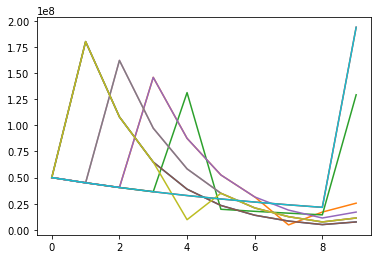

In [19]:
plt.figure()
for i in range(10):
    plt.plot(pmt_pri[i])
plt.show()

Incorporate servicing fee:

In [20]:
SERVICE_FEE = 20 / 10_000

pmt_pri *= 1 - SERVICE_FEE
pmt_int *= 1 - SERVICE_FEE

# Valuation

In [21]:
DCF = np.cumprod(1 / (1 + r), axis=1)

# 1. Roll Over Treasuries

In [22]:
temp = np.ones(N_paths) * F

for i in range(3):
    temp *= 1 + r[:, i]
    temp -= borrow_cf[:, i]

PV_tsy = temp * DCF[:, 2] - F * DCF[:, 2]

print('E[PV_tsy] = {:.3f} MM, StdDev[PV_tsy] = {:.3f} MM'.format(PV_tsy.mean() / 1_000_000, PV_tsy.std() / 1_000_000))

E[PV_tsy] = -6.889 MM, StdDev[PV_tsy] = 0.328 MM


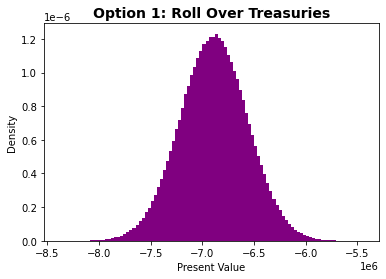

In [23]:
plt.figure()
plt.hist(PV_tsy, bins=100, density=True, color='purple')
plt.title('Option 1: Roll Over Treasuries', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

In [24]:
temp = PV_tsy.copy()
temp.sort()
print(temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)])
del temp

-7429278.907758594 -7654616.731200278


# 2. Roll Over Eurodollars

In [25]:
temp = np.ones(N_paths) * F

for i in range(3):
    temp *= 1 + lib[:, i]
    temp -= borrow_cf[:, i]

PV_euro = temp * DCF[:, 2] - F * DCF[:, 2]

print('E[PV_euro] = {:.3f} MM, StdDev[PV_euro] = {:.3f} MM'.format(PV_euro.mean() / 1_000_000, PV_euro.std() / 1_000_000))

E[PV_euro] = 4.974 MM, StdDev[PV_euro] = 0.023 MM


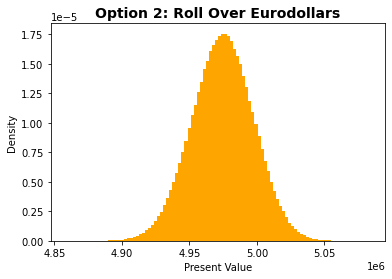

In [26]:
plt.figure()
plt.hist(PV_euro, bins=100, density=True, color='orange')
plt.title('Option 2: Roll Over Eurodollars', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

In [27]:
temp = PV_euro.copy()
temp.sort()
print(temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)])
del temp

4936670.270031333 4920653.39270252


# 3. GNMA ARMs

In [28]:
PV_arm = np.sum((pmt_int + pmt_pri) * DCF, axis=1)

print('E[PV_arm] = {:.3f} MM, StdDev[PV_arm] = {:.3f} MM'.format(PV_arm.mean() / 1_000_000, PV_arm.std() / 1_000_000))

E[PV_arm] = 516.237 MM, StdDev[PV_arm] = 2.506 MM


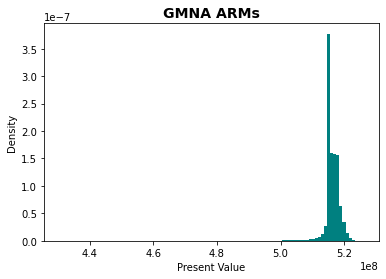

In [29]:
plt.figure()
plt.hist(PV_arm, bins=100, density=True, color='teal')
plt.title('GMNA ARMs', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

## Client PnL

In [30]:
# (-) : Pays F back to their parent bank : @ t = 3
# (-) : Pays funding costs (LIBOR - 35 bps) to their parent bank : @ t = 1, 2, 3
# (+) : Receives swap payments from Wright Derivatives : @ t = 1, 2, 3
# (+) : Receives repurchase payment (repo) from Wright Derivatives : @ t = 3

SPREAD_SWAP = 5 / 10_000
# REPO = np.sum(((pmt_pri + pmt_int) * DCF)[:, 3:], axis=1).mean()
REPO = F

swap_cf = F * (lib[:, :3] + SPREAD_SWAP)

PV_client = 0
PV_client -= F * DCF[:, 2]
PV_client -= np.sum(borrow_cf * DCF[:, :3], axis=1)
PV_client += np.sum(swap_cf * DCF[:, :3], axis=1)
PV_client += REPO * DCF[:, 2]

PV_client.mean() / 1_000_000, PV_client.std() / 1_000_000

(5.634414530713934, 0.025668578157914367)

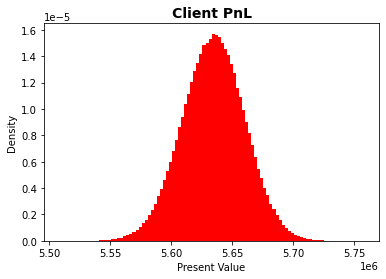

In [31]:
plt.figure()
plt.hist(PV_client, bins=100, density=True, color='red')
plt.title('Client PnL', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

In [32]:
temp = PV_client.copy()
temp.sort()
print(temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)])
del temp

5591780.702285945 5573690.615585923


## Team PnL

In [33]:
# (+) : Receives all cash flows from the GMNA ARMs : @ t = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
# (-) : Pays swap payments to CBC : @ t = 1, 2, 3
# (-) : Pays repurchase payment (repo) to CBC : @ t = 3

PV_team = 0
PV_team += np.sum((pmt_pri + pmt_int) * DCF, axis=1)
PV_team -= np.sum(swap_cf * DCF[:, :3], axis=1)
PV_team -= REPO * DCF[:, 2]

PV_team.mean() / 1_000_000, PV_team.std() / 1_000_000

(3.713136685646827, 2.527767373749116)

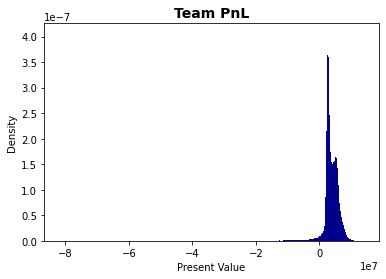

In [34]:
plt.figure()
plt.hist(PV_team, bins=1_000, density=True, color='darkblue')
plt.title('Team PnL', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

In [35]:
temp = PV_team.copy()
temp.sort()
print(temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)])
del temp

1465374.6039022207 -5703466.274999082


# Hedged Team PnL

In [36]:
def squared_diff_swap(_K):
    return np.abs(np.sum((lib[:, :3] + SPREAD_SWAP - _K) * DCF[:, :3], axis=1).mean())

result = so.minimize(squared_diff_swap, 0.02)
K_1 = float(result.x.round(4))
del squared_diff_swap

def squared_diff_swap(_K):
    return np.abs(np.sum((_K - r[:, :3]) * DCF[:, :3], axis=1).mean())

result = so.minimize(squared_diff_swap, 0.02)
K_2 = float(result.x.round(4))
del squared_diff_swap

In [37]:
K_1, K_2

(0.0414, 0.0325)

In [38]:
K_cap = 0.04
PV_caplet = (np.maximum(0, 100 * (r[:, 3] - K_cap)) * DCF[:, 2]).mean()

PV_caplet

0.09719539735512985

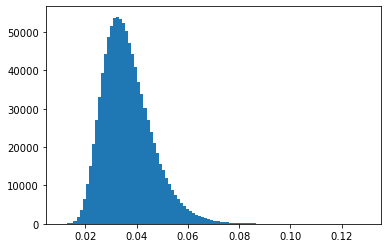

In [39]:
plt.hist(r[:, 8], bins=100)
plt.show()

In [40]:
# (+) : Receives all cash flows from the GMNA ARMs : @ t = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
# (-) : Pays swap payments to CBC : @ t = 1, 2, 3
# (-) : Pays repurchase payment (repo) to CBC : @ t = 3

# (/) : Interest rate swap with third party, fixed  : @ t = 1, 2, 3
# (/) : Interest rate swap with third party : @ t = 1, 2, 3
# () : Cap

PV_team_h = 0
PV_team_h += np.sum((pmt_pri + pmt_int) * DCF, axis=1)
PV_team_h -= np.sum(swap_cf * DCF[:, :3], axis=1)
PV_team_h -= REPO * DCF[:, 2]
PV_team_h += np.sum(F * (lib[:, :3] + SPREAD_SWAP - K_1) * DCF[:, :3], axis=1)
PV_team_h += np.sum(F * (K_2 - r[:, :3]) * DCF[:, :3], axis=1)
# PV_team_h += 10_000_000 * (np.maximum(0, 100 * (r[:, 2] - K_cap)) * DCF[:, 2] - PV_caplet)

PV_team_h.mean() / 1_000_000, PV_team_h.std() / 1_000_000

(3.7002789681029404, 2.503669367563012)

In [41]:
10_000_000 * PV_caplet, PV_caplet

(971953.9735512985, 0.09719539735512985)

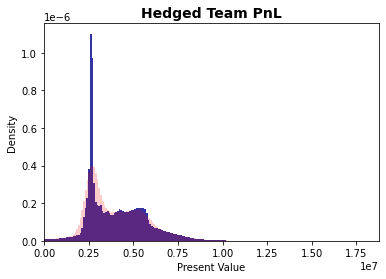

In [42]:
plt.figure()
plt.hist(PV_team_h, bins=1_000, density=True, alpha=0.8, color='darkblue')
plt.hist(PV_team, bins=1_000, density=True, alpha=0.2, color='red')
plt.title('Hedged Team PnL', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.xlim(0)
plt.show()

In [43]:
temp = PV_team_h.copy()
temp.sort()
print(temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)])
del temp

1513547.5885743853 -5676909.575386915


# Hedging

In [44]:
TXN_COST = 1 / 10_000

N_cap2, K_cap2 = 10_000_000, 0.0375
N_cap3, K_cap3 = 10_000_000, 0.04

# Price of a cap in year 2
price_cap2 = np.mean(np.maximum(0, 100 * (r[:, 1] - K_cap2)) * DCF[:, 1])
# Price of a cap in year 3
price_cap3 = np.mean(np.maximum(0, 100 * (r[:, 2] - K_cap3)) * DCF[:, 2])

# Present value of cap cash flows in year 2
PV_cap2 = N_cap2 * ( np.maximum(0, 100 * (r[:, 1] - K_cap2)) * DCF[:, 1] - price_cap2 * (1 + TXN_COST) )
# Present value of cap cash flows in year 3
PV_cap3 = N_cap3 * ( np.maximum(0, 100 * (r[:, 2] - K_cap3)) * DCF[:, 2] - price_cap3 * (1 + TXN_COST) )

# Print money spent on year 2 cap
print(N_cap2 * price_cap2 * (1 + TXN_COST) / 1_000_000)
# Print money spent on year 3 cap
print(N_cap3 * price_cap3 * (1 + TXN_COST) / 1_000_000)

0.3622772745564171
0.5681386066387525


In [45]:
# (+) : Receives all cash flows from the GMNA ARMs : @ t = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
# (-) : Pays swap payments to CBC : @ t = 1, 2, 3
# (-) : Pays repurchase payment (repo) to CBC : @ t = 3

# (/) : Interest rate swap with third party, fixed  : @ t = 1, 2, 3
# (/) : Interest rate swap with third party : @ t = 1, 2, 3

PV_team_h2 = 0
PV_team_h2 += np.sum((pmt_pri + pmt_int) * DCF, axis=1)
PV_team_h2 -= np.sum(swap_cf * DCF[:, :3], axis=1)
PV_team_h2 -= REPO * DCF[:, 2]

PV_team_h2 += np.sum(F * (lib[:, :3] + SPREAD_SWAP - K_1) * DCF[:, :3], axis=1)
PV_team_h2 += np.sum(F * (K_2 - r[:, :3]) * DCF[:, :3], axis=1)

PV_team_h2 += PV_cap2
PV_team_h2 += PV_cap3

PV_team_h2.mean() / 1_000_000, PV_team_h2.std() / 1_000_000

(3.7001859358180513, 2.56616933280511)

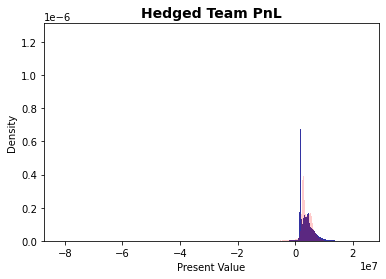

In [46]:
plt.figure()
plt.hist(PV_team_h2, bins=1_000, density=True, alpha=0.8, color='darkblue')
plt.hist(PV_team, bins=1_000, density=True, alpha=0.2, color='red')
plt.title('Hedged Team PnL', fontweight='bold', fontsize=14)
plt.xlabel('Present Value'); plt.ylabel('Density')
plt.show()

In [48]:
temp = PV_team_h2.copy()
temp.sort()
print("95 percentile scenario and 5 percentile scenario PnL:")
print([temp[int((1 - 0.95) * N_paths)], temp[int((1 - 0.99) * N_paths)]])
del temp

95 percentile scenario and 5 percentile scenario PnL:
[1443545.710137925, -1084970.0026535622]
